# Lungs Segmentation
The segmentation of lungs may, possibly, proceed directly in 3D as follows:
1. Run binarization of the CT image using a threshold of -320 HU – every voxel
with HU lower than this threshold should receive label 1 (air label) and the
remaining voxels should receive label 0
2. Use body mask to select only air regions within body
3. Design a sequence of morphological (and other appropriate) operations to fill
the holes in the interior of lungs and to remove ‘air’ clusters which do not
correspond to lungs (e.g. gas in bowels) – at the end one should be left with
clusters which correspond only to airways
4. Use watershed from markers (scikit-image -> segmentation -> watershed) to
extract the left and the right lung from the segmentation being the result of step
(3) above. Before using watershed design a procedure for defining the three
markers (marker of left lung, marker of right lung, marker of background).
5. To compare segmentation results with reference segmentations available at
Lab One Drive use Dice coefficient and Hausdorff distance (find the definitions of
these   quantities)   as   implemented   in   surface-distance   [package](https://github.com/google-deepmind/surface-distance).
The project results (Dice coefficients and Hausdorff distance) should be
reported   for   the   three   tasks:   body   mask   segmentation,   left   lung
segmentation, right lung segmentation.


## Imports

In [1]:
import numpy as np
import nibabel as nib
import cv2
from skimage import morphology, measure
from skimage.segmentation import watershed
from skimage import filters
from scipy import ndimage
import matplotlib.pyplot as plt
# from pycimg import CImg

import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import flood


TODO
#body
Body:
binarization
opening
flood_fill

#binarize lungs
Do histogram of the image
do kmeans to get threashold
do binarization with threashold

#lung segmentation


## Load / save .nii files and Visualization

In [2]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, *slices: int) -> None:
    num_slices = len(slices)
    plt.figure(figsize=(15, 5 * num_slices))  # Adjust figure size based on the number of slices

    for i, slice_num in enumerate(slices):
        # Original slice
        plt.subplot(num_slices, 3, 3 * i + 1)
        plt.title(f"Original Slice {slice_num}")
        plt.imshow(original[:, :, slice_num], cmap="gray")
        
        # Segmented slice
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.title(f"Segmented Slice {slice_num}")
        plt.imshow(segmented[:, :, slice_num], cmap="gray")
        
        # Reference slice
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.title(f"Reference Slice {slice_num}")
        plt.imshow(reference[:, :, slice_num], cmap="gray")

    plt.tight_layout() 
    plt.show()

## 1. Body differentiation

In [3]:
class Transforms:
    def __init__(self):
        pass
        
    def binarize_images(self, image: np.ndarray, threshold: float = -320, use_otsu: bool = False) -> np.ndarray:
        threshold = filters.threshold_otsu(image) if use_otsu else threshold
        image = np.where(image < threshold, 1, 0)
        return image.astype(np.uint8)
    
    def binarize_images_kmeans(self, image: np.ndarray, max_iter: int = 100) -> float:
        threshold = image.mean()
        prev_threshold = 0
        
        for _ in range(max_iter):
            foreground = image[image > threshold]
            background = image[image <= threshold]
            new_threshold = (foreground.mean() + background.mean()) / 2
            
            if abs(new_threshold - prev_threshold) < 0.1:
                break
            
            prev_threshold = threshold
            threshold = new_threshold
            
        image = np.where(image < threshold, 1, 0)
        return image.astype(np.uint8)

In [4]:
class BodyMask(Transforms):
    def __init__(self, image: np.ndarray):
        self.img: np.ndarray = image
        
    def initial_transform(self) -> np.ndarray:
        binary_image = self.binarize_images_kmeans(self.img)
        opened_img = morphology.binary_opening(binary_image, morphology.ball(7))
        visualize_photos(self.img, opened_img, self.img, 30, 60, 90, 110)
        self.img = opened_img
        
    def flood_fill_3d(self, seed_point: tuple = (0, 0, 0)) -> np.ndarray:
        labels = label(self.img, connectivity=1)
        regions = regionprops(labels)
        largest_region = max(regions, key=lambda x: x.area)
        
        mask = flood(self.img, seed_point, tolerance=0.1)
        
        mask = mask * largest_region.image
        mask = np.logical_not(mask)
        return mask
    
    
    def flood_fill_3d2(self) -> np.ndarray:
        filled = flood(self.imgs, (0, 0, 0), connectivity=1)
        negated = np.logical_not(filled)
        
        labeled_components, num_labels = label(negated, return_num=True, connectivity=1)
        # largest connected component
        regions = regionprops(labeled_components)
        if not regions: # no components -> empty array
            return np.zeros_like(self.imgs)  
        
        largest_region = max(regions, key=lambda r: r.area)
        largest_component_mask = labeled_components == largest_region.label
        
        return largest_component_mask


## 3. Sequence of morphological operations

In [5]:
def transform_3d(imgs: np.ndarray, min_lung_size: int = 1000) -> np.ndarray:
    return np.array([transform_2d(img_slice, min_lung_size) for img_slice in imgs])


def transform_2d(img: np.ndarray, min_lung_size: int = 1000) -> np.ndarray:
    if len(img.shape) == 3 and img.shape[2] == 3: # check greyscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((5, 5), np.uint8)
    closed_image = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    img_filled = ndimage.binary_fill_holes(opened_image)
    components, num_labels = ndimage.label(img_filled)
    lung_candidates = morphology.remove_small_objects(components, min_size=min_lung_size)

    lungs_mask = lung_candidates > 0

    return lungs_mask.astype(np.uint8)

## 4. Watershed 

## 5. Evaluation

## Main

In [6]:
def main(img_path: str,reference_img_path: str, body_mask_path: str, output_path: str, ) -> None:
    # load images
    img, affine = load_nii_gz_file(img_path)
    body_masks, _ = load_nii_gz_file(body_mask_path)
    reference_img, _ = load_nii_gz_file(reference_img_path)

    # transform
    body = BodyMask(img)
    body.initial_transform()
    body_mask = body.flood_fill_3d()
    
    visualize_photos(body_mask, body_masks, abs(body_mask - body_masks), 50, 70, 100, 120)
    # print("Dice_coefficient, Hausdorff_distance", calculate_score(imgs_transform, reference_img))

## Run code

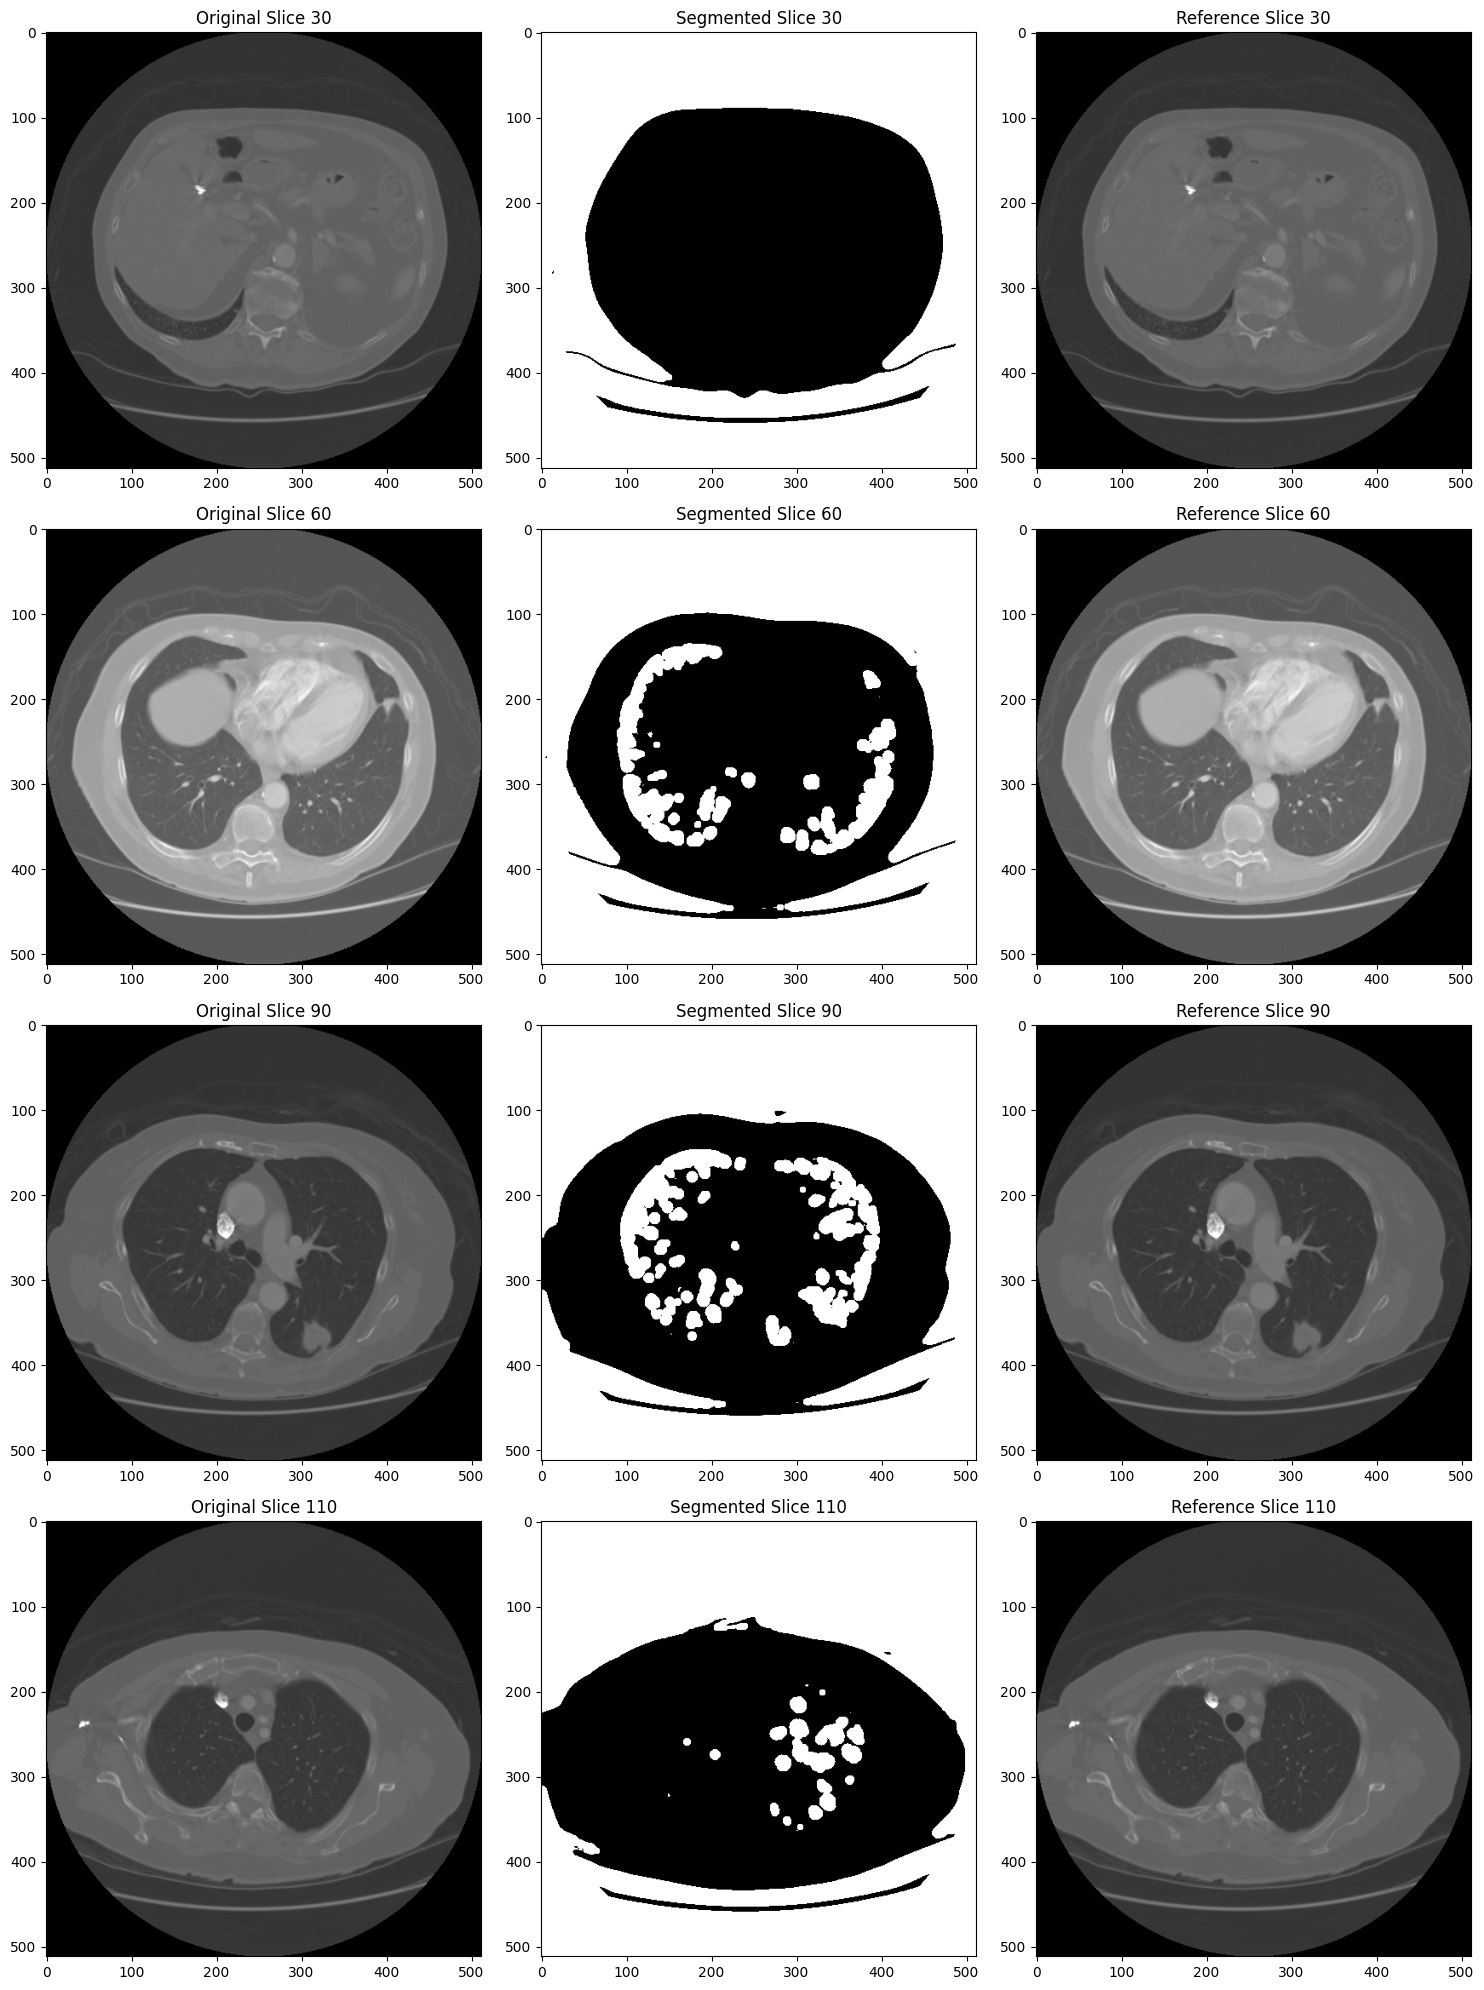

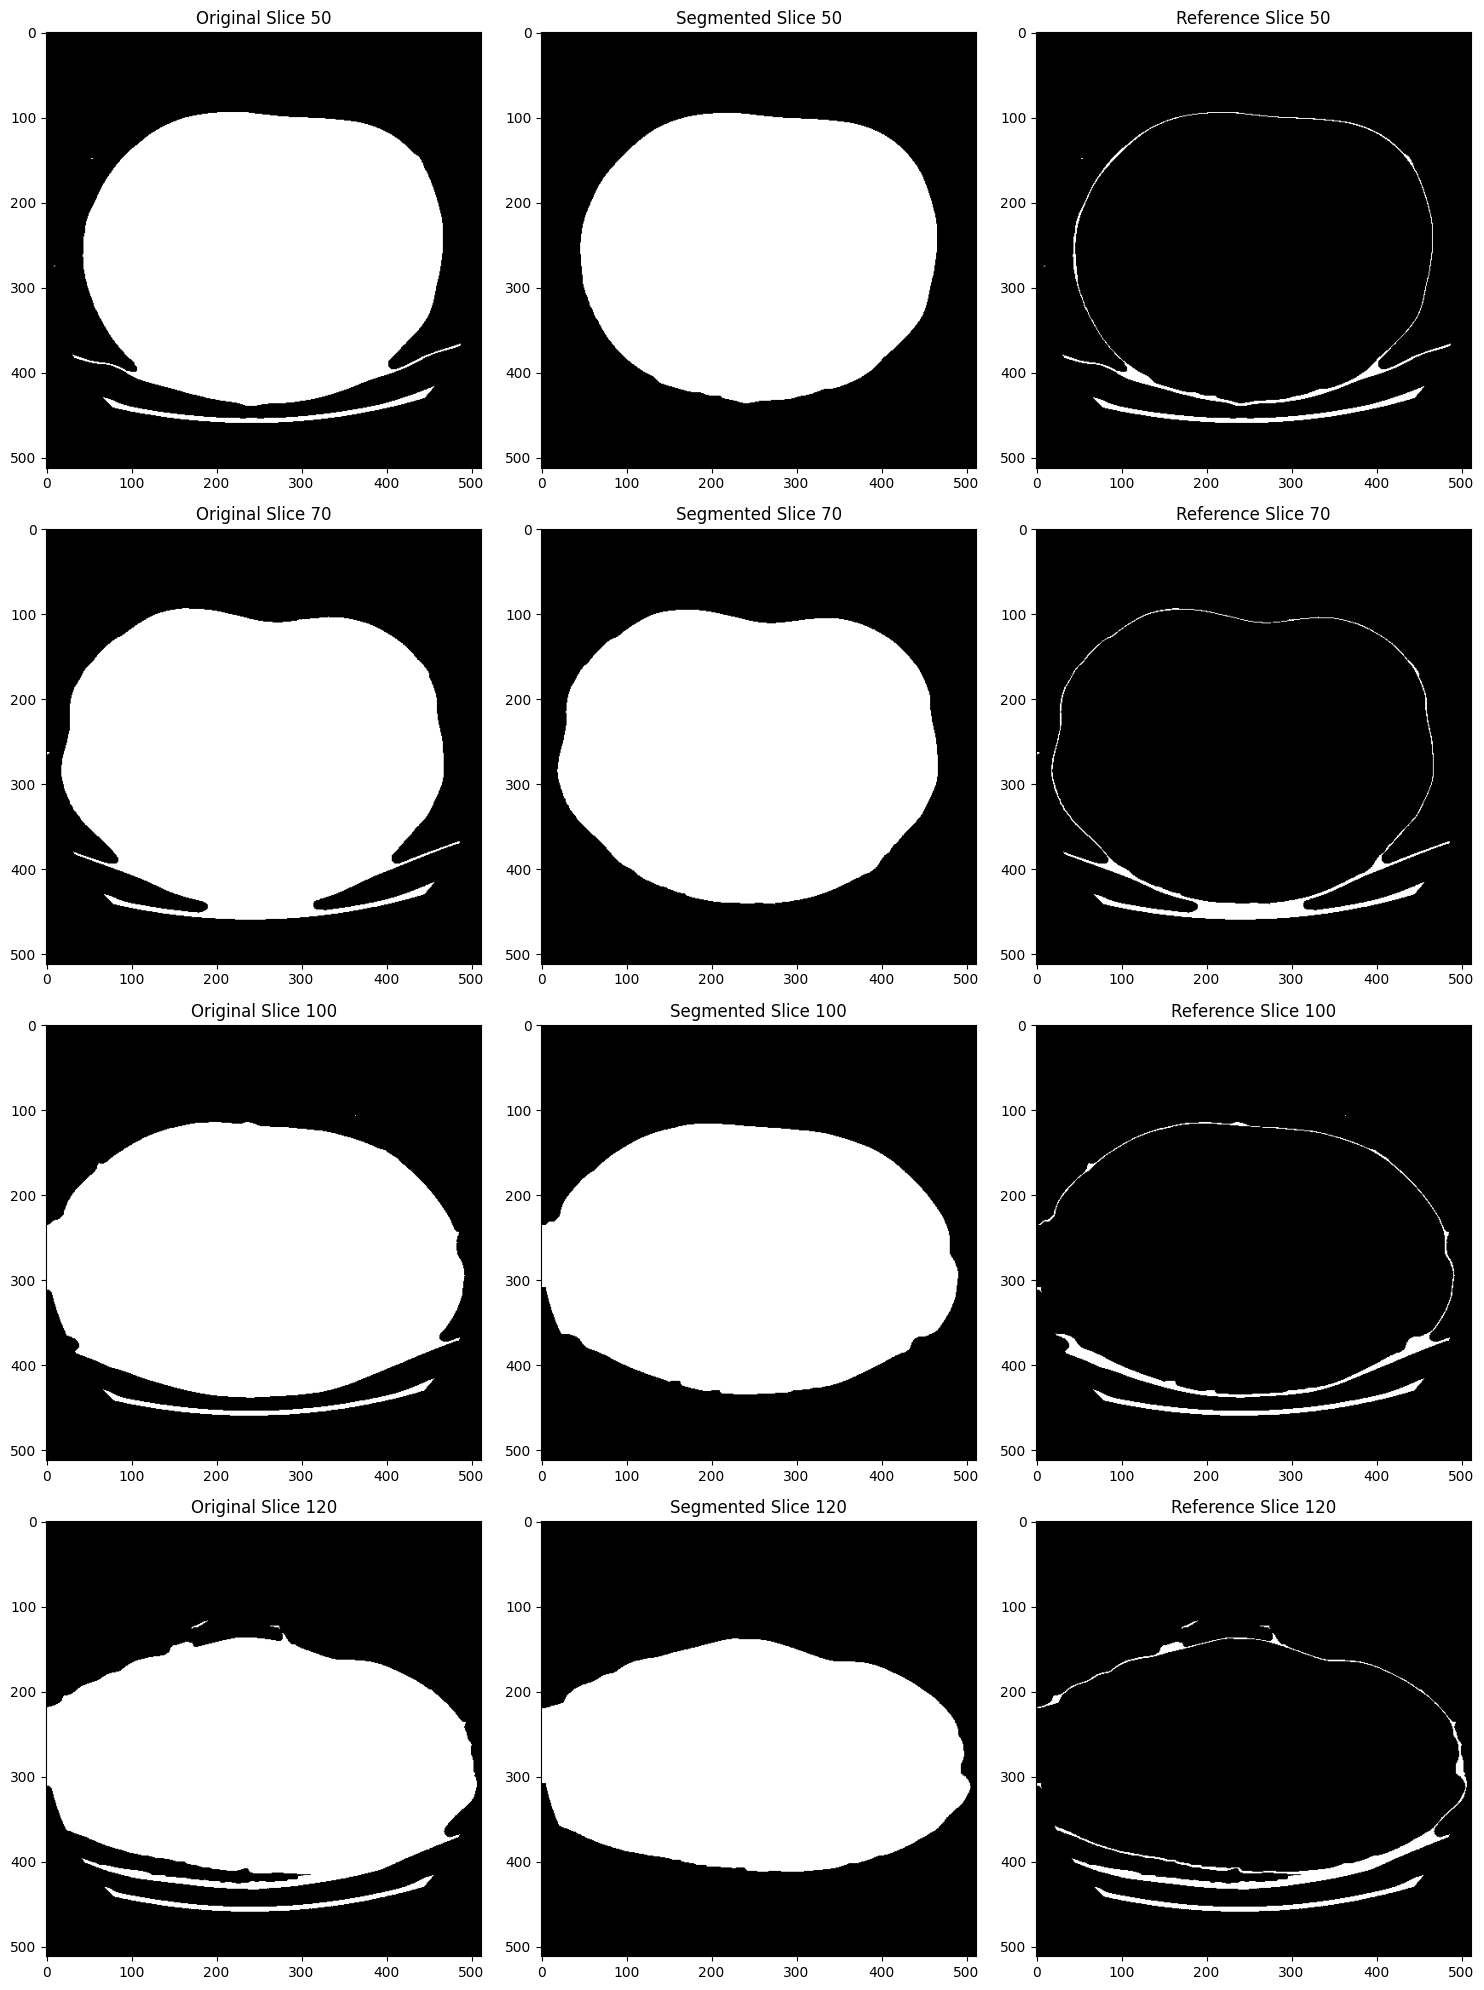

In [7]:
main('Images/IMG_0001.nii.gz','ReferenceSegmentations/LUNGS_IMG_0001.nii.gz', 'BodyMasks/BODYMASK_IMG_0001.nii.gz', 'output.nii.gz')
